# Clustering Reddit Comments: Approach Outline

Our goal is to determine if clustering can effectively group Reddit comments with similar topics or content. We will focus initially on the **`body`** column, filtering for comments that meet a minimum length requirement (greater than 20 words).


Resulting clusters will help us understand whether clustering can effectively capture topic similarities within the Reddit comment dataset.


---

#### 1. **Filter Comments**
   - **Select Comments**: Use only comments from the **`body`** column.
   - **Length Requirement**: Include only comments with more than 10 words to ensure relevance and sufficient content for clustering.


In [44]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import psycopg2
import pandas as pd

# Function to load data into a DataFrame
def load_data_to_dataframe():
    try:
        # Establish a connection to the PostgreSQL database
        connection = psycopg2.connect(
            host='10.10.10.10',  # Replace with your host
            port=5432,           # Default PostgreSQL port
            user='postgres',     # Replace with your username
            password='adm',      # Replace with your password
            database='adm'       # Replace with your database name
        )
        
        # Create a SQL query to retrieve 10,000 records
        query = "SELECT body FROM reddit_2007 WHERE body != '[deleted]' and length(body) > 100 limit 30000;"

        # Load the data into a pandas DataFrame
        df = pd.read_sql_query(query, connection)

    except Exception as e:
        print("An error occurred:", e)

    finally:
        # Close the connection
        if connection:
            connection.close()
    
    return df

# Call the function to load data into a DataFrame
data = load_data_to_dataframe()
df = pd.DataFrame(data['body'].values, columns=["text"])

C:\Users\Marcin\AppData\Local\Temp\ipykernel_3352\3410500325.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [2]:
df.head()

,text
0,&gt; And yet none of those are mainstream scie...
1,"Sheesh, ease up, o angry Toshiba fanboy! Don't..."
2,I agree. If Clebus has a $30K job and thinks ...
3,"&gt;And once he is confirmed, then the Congres..."
4,"Things you'll tell your grandkids: 'In my day,..."


In [3]:
df.describe()

,text
count,30000
unique,29868
top,"Robert Priddy (aka ""truthpromoter"") was a devo..."
freq,61


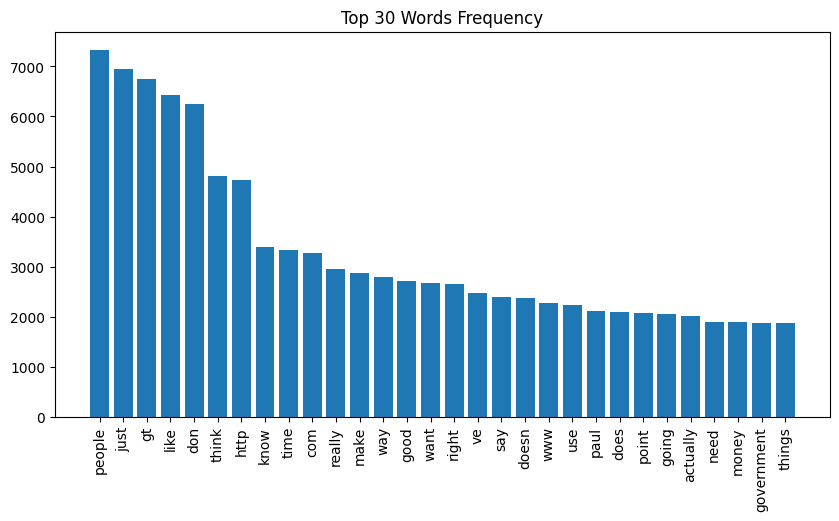

In [4]:
# word frequency histogram

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Vectorize the text data to count word occurrences
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(data['body'].values)

# Sum up the counts of each word in the vocabulary
word_counts = X_counts.toarray().sum(axis=0)
word_freq = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Plot the top 30 most frequent words
words = [wf[0] for wf in word_freq[:30]]
counts = [wf[1] for wf in word_freq[:30]]
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title("Top 30 Words Frequency")
plt.show()

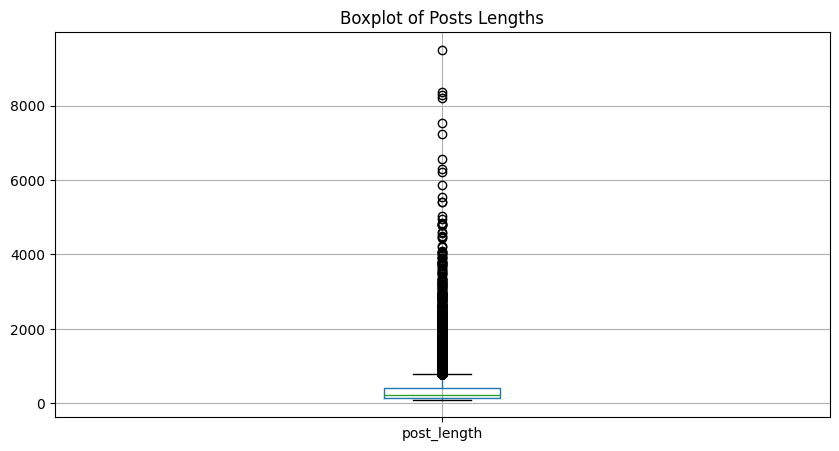

In [5]:
# Calculate the length of each document
df['post_length'] = df['text'].apply(len)

# Plot a boxplot of document lengths
plt.figure(figsize=(10, 5))
df.boxplot(column='post_length')
plt.title("Boxplot of Posts Lengths")
plt.show()

---

#### 2. **Basic Data Cleaning**
   - **Remove Non-Word Characters**: Strip all punctuation, special symbols, and other non-word characters.
   - **Remove Digits**: Delete any numeric characters.
   - **Convert to Lowercase**: Standardize text to lowercase for uniformity.
   - **Apply Stemming**: Reduce words to their root forms to help with generalization.

In [6]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marcin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---

#### 3. **TF-IDF Transformation**
   - **Transform Text**: Use **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert the cleaned text data into numerical features. This will highlight terms that are important in specific comments but uncommon across all comments.
   - **Data for Clustering**: The resulting TF-IDF vectors will serve as input data for clustering.


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

In [21]:
X_tfidf.shape

(30000, 500)

---

#### 4. **Clustering**
   - **KMeans**
   - **DBSCAN**
   - **AgglomerativeClustering**

In [23]:
from sklearn.cluster import KMeans

# Apply K-Means with a predetermined number of clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Get the cluster assignments
labels_kmeans = kmeans.labels_
df['cluster_kmeans'] = labels_kmeans

In [24]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan.fit(X_tfidf)

# Get the cluster assignments
labels_dbscan = dbscan.labels_
df['cluster_dbscan'] = labels_dbscan

In [11]:
# from sklearn.cluster import AgglomerativeClustering

# # Apply Agglomerative Hierarchical Clustering
# agglo = AgglomerativeClustering(n_clusters=num_clusters, linkage='average')
# agglo.fit(X_tfidf.toarray())

# # Get the cluster assignments
# labels_agglo = agglo.labels_
# df['cluster_agglo'] = labels_agglo

In [25]:
from sklearn_extra.cluster import KMedoids

# Apply K-Medoids with a predetermined number of clusters
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42, metric='cosine')
kmedoids.fit(X_tfidf)

# Get the cluster assignments
labels_kmedoids = kmedoids.labels_
df['cluster_kmedoids'] = labels_kmedoids

---

#### 5. **Results evaluation**

In [26]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for each clustering algorithm
sil_score_kmeans = silhouette_score(X_tfidf, labels_kmeans)
sil_score_dbscan = silhouette_score(X_tfidf, labels_dbscan)
# sil_score_agglo = silhouette_score(X_tfidf, labels_agglo)
sil_score_kmedoids = silhouette_score(X_tfidf, labels_kmedoids)

print(f'Silhouette Score for K-Means: {sil_score_kmeans}')
print(f'Silhouette Score for DBSCAN: {sil_score_dbscan}')
# print(f'Silhouette Score for Agglomerative Clustering: {sil_score_agglo}')
print(f'Silhouette Score for KMedoids Clustering: {sil_score_kmedoids}')

Silhouette Score for K-Means: 0.010358061937199478
Silhouette Score for DBSCAN: -0.031073561992802978
Silhouette Score for KMedoids Clustering: 0.0025053729021651265


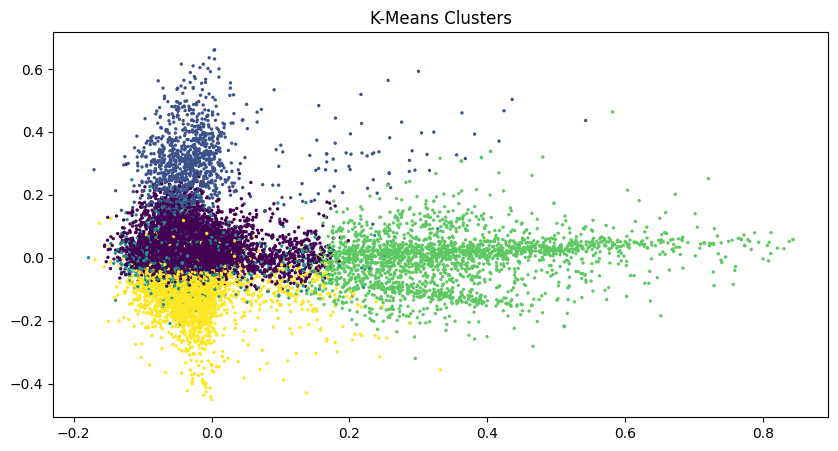

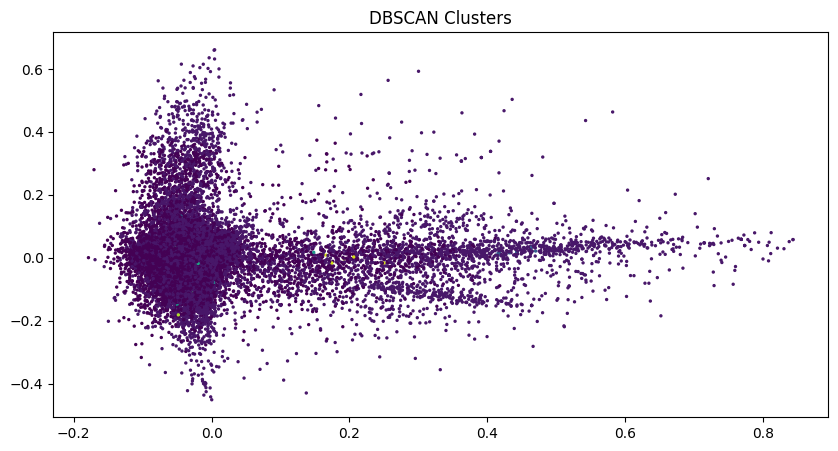

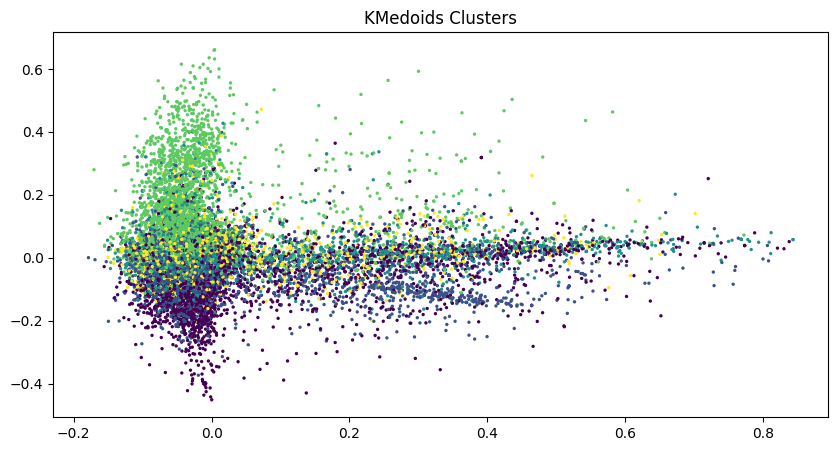

In [27]:
from sklearn.decomposition import PCA

# Function to plot clusters
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=2)
    plt.title(title)
    plt.show()

# Reduce dimensions to 2 for visualization
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())

# Visualize clusters
plot_clusters(X_pca, labels_kmeans, 'K-Means Clusters')
plot_clusters(X_pca, labels_dbscan, 'DBSCAN Clusters')
# plot_clusters(X_pca, labels_agglo, 'Agglomerative Clustering Clusters')
plot_clusters(X_pca, labels_kmedoids, 'KMedoids Clusters')

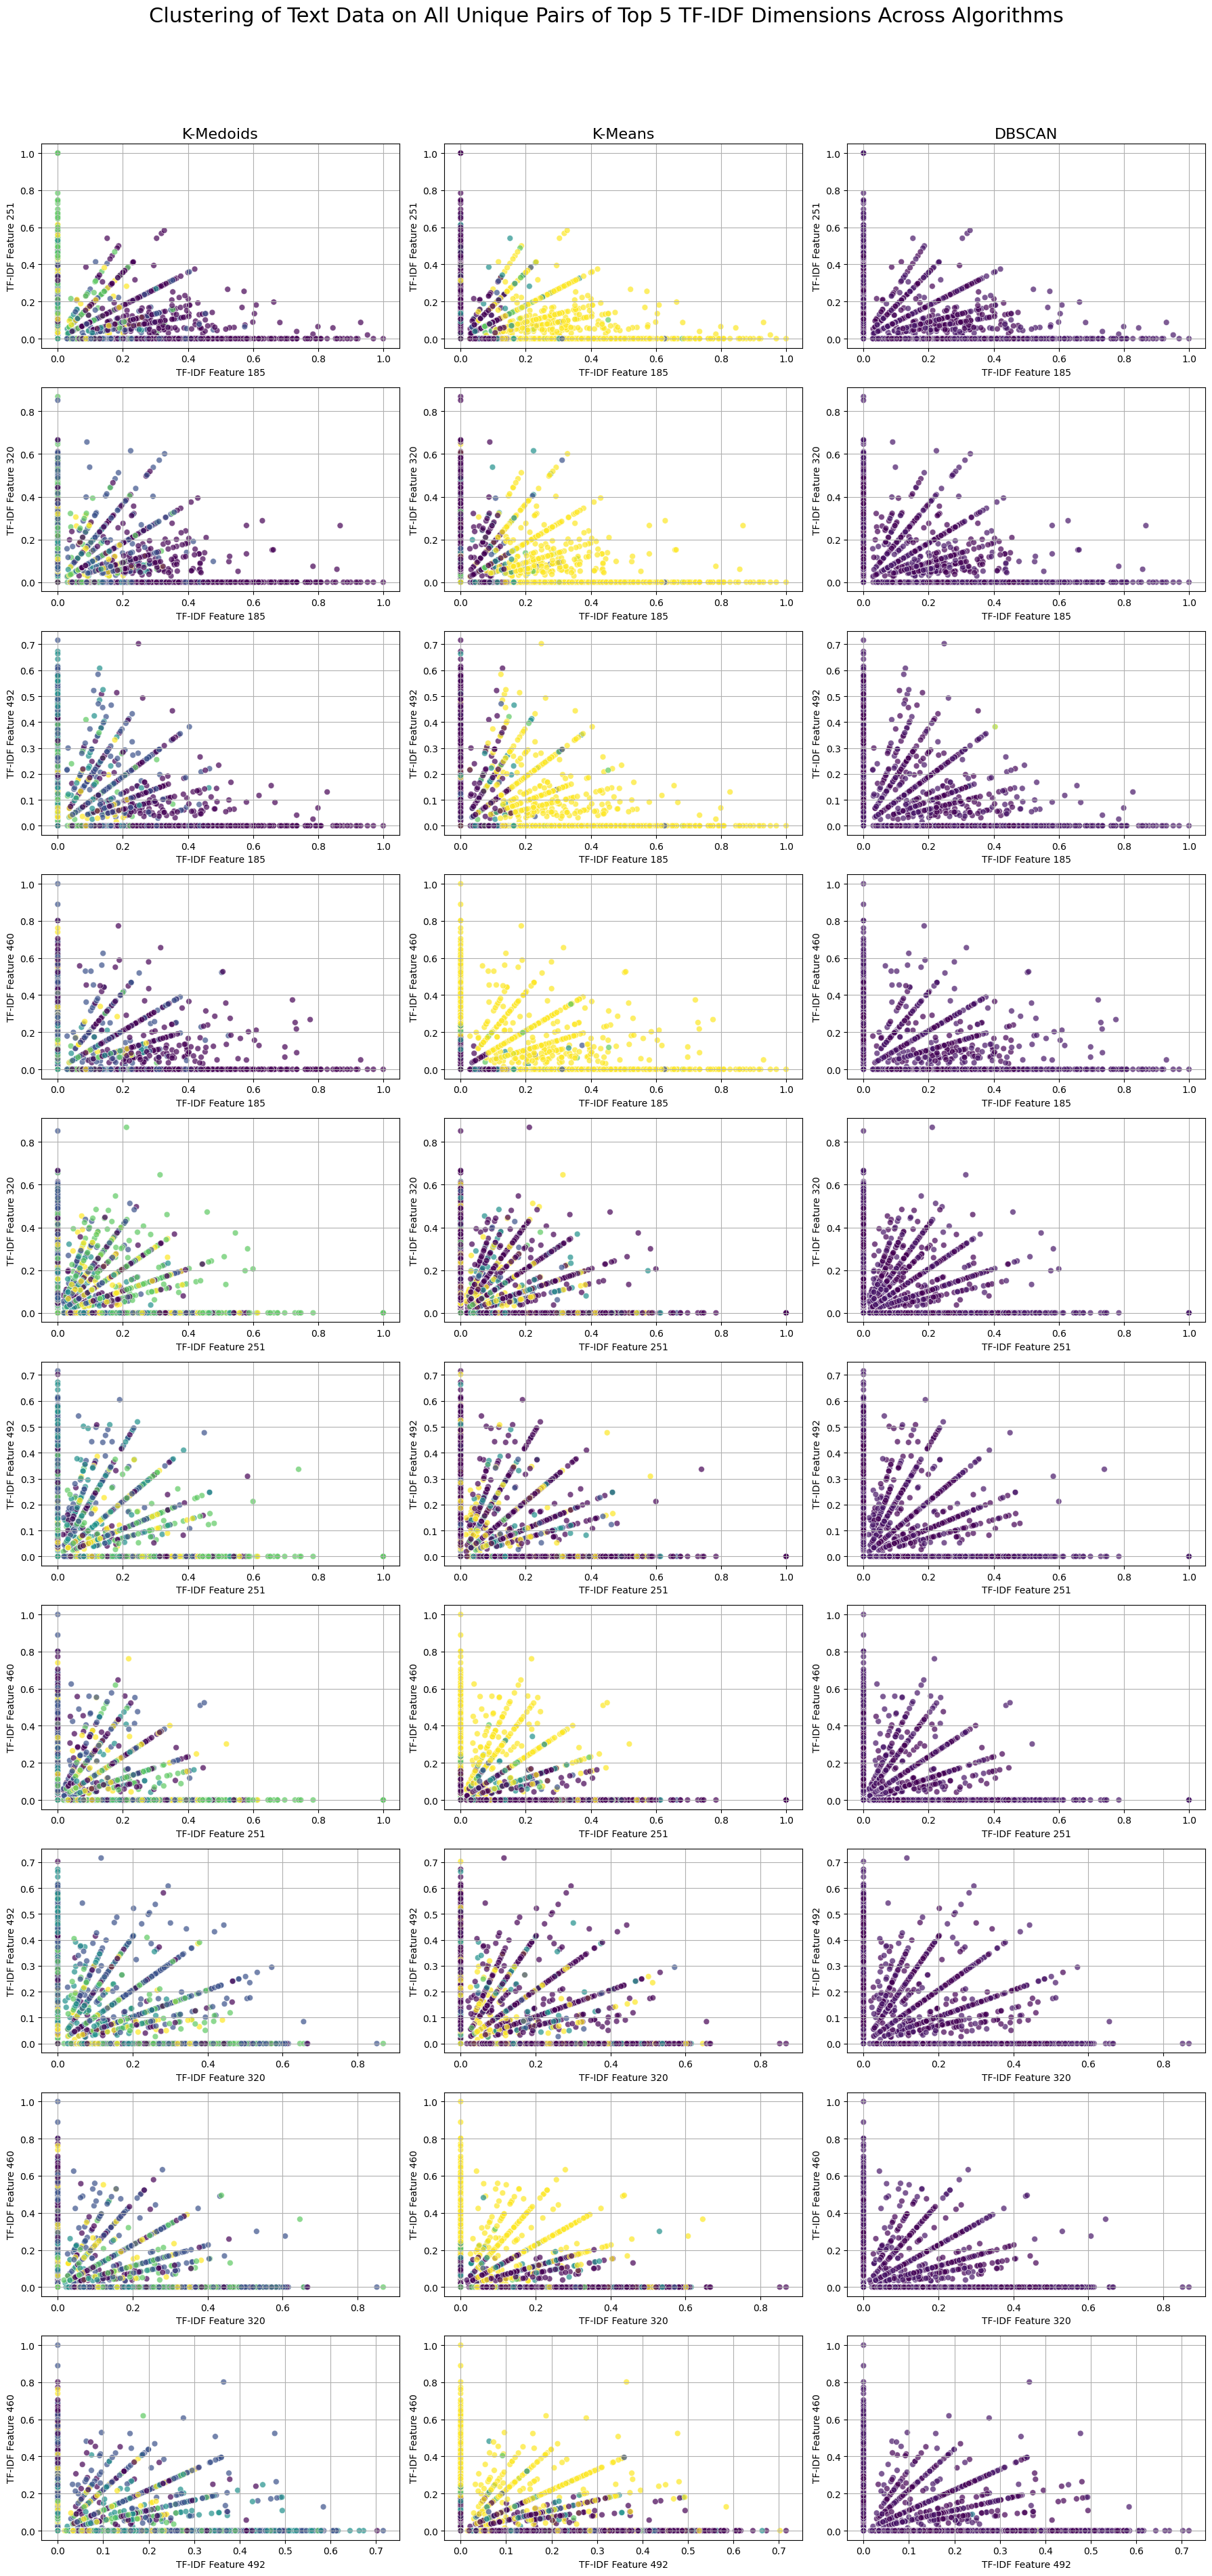

In [43]:
X_dense = X_tfidf.toarray()
variances = np.var(X_dense, axis=0)
feature_indices = np.arange(X_dense.shape[1])

feature_variances = pd.DataFrame({
    'Feature Index': feature_indices,
    'Variance': variances
})
feature_vars = feature_variances.sort_values(by='Variance', ascending=False)['Feature Index'].astype(int).values[:5]

dim_indices = list(itertools.combinations(feature_vars, 2))

fig, axes = plt.subplots(10, 3, figsize=(18, 40))
fig.suptitle('Clustering of Text Data on All Unique Pairs of Top 5 TF-IDF Dimensions Across Algorithms', fontsize=22)

clustering_algorithms = [
    (labels_kmedoids, 'K-Medoids'),
    (labels_kmeans, 'K-Means'),
    (labels_dbscan, 'DBSCAN')
]

for row_idx, (dim1_index, dim2_index) in enumerate(dim_indices):
    for col_idx, (labels, cluster_name) in enumerate(clustering_algorithms):
        X_selected = X_dense[:, [dim1_index, dim2_index]]
        
        ax = axes[row_idx, col_idx]
        sns.scatterplot(
            x=X_selected[:, 0], y=X_selected[:, 1],
            hue=labels, palette='viridis', alpha=0.7, s=40, ax=ax, legend=None
        )
        
        if row_idx == 0:
            ax.set_title(f'{cluster_name}', fontsize=16)
        
        ax.set_xlabel(f'TF-IDF Feature {dim1_index}')
        ax.set_ylabel(f'TF-IDF Feature {dim2_index}')
        ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Calculating Silhouette for different number of clusters

Number of Clusters: 3, Silhouette Score: 0.0036
Number of Clusters: 5, Silhouette Score: 0.0104
Number of Clusters: 10, Silhouette Score: 0.0146
Number of Clusters: 15, Silhouette Score: 0.0178
Number of Clusters: 20, Silhouette Score: 0.0202
Number of Clusters: 25, Silhouette Score: 0.0214
Number of Clusters: 30, Silhouette Score: 0.0238
Number of Clusters: 40, Silhouette Score: 0.0265
Number of Clusters: 50, Silhouette Score: 0.0286
Number of Clusters: 100, Silhouette Score: 0.0359
Number of Clusters: 150, Silhouette Score: 0.0389
Number of Clusters: 200, Silhouette Score: 0.0045
Number of Clusters: 300, Silhouette Score: 0.0040
Number of Clusters: 500, Silhouette Score: 0.0001
Number of Clusters: 1000, Silhouette Score: -0.0117


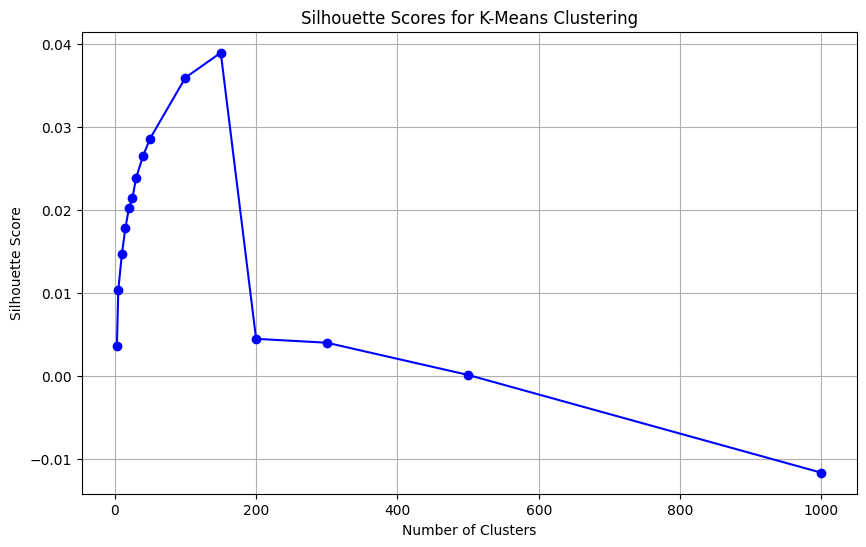

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

cluster_range = [3, 5, 10, 15, 20, 25, 30, 40 , 50, 100, 150, 200, 300, 500, 1000]
silhouette_scores = []

# Loop over each cluster count and compute silhouette score
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_tfidf)
    
    # Get cluster assignments
    labels_kmeans = kmeans.labels_
    
    # Calculate silhouette score
    sil_score_kmeans = silhouette_score(X_tfidf, labels_kmeans)
    silhouette_scores.append(sil_score_kmeans)
    print(f"Number of Clusters: {num_clusters}, Silhouette Score: {sil_score_kmeans:.4f}")

# Plot silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Scores for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Elbow method to obtain the best number of clusters

Number of Clusters: 3, Inertia: 28746.72
Number of Clusters: 5, Inertia: 28273.50
Number of Clusters: 10, Inertia: 27708.83
Number of Clusters: 15, Inertia: 27309.97
Number of Clusters: 20, Inertia: 27009.37
Number of Clusters: 25, Inertia: 26796.36
Number of Clusters: 30, Inertia: 26549.39
Number of Clusters: 40, Inertia: 26139.47
Number of Clusters: 50, Inertia: 25796.68
Number of Clusters: 100, Inertia: 24354.75
Number of Clusters: 150, Inertia: 23424.32
Number of Clusters: 200, Inertia: 23284.81
Number of Clusters: 300, Inertia: 22416.74
Number of Clusters: 500, Inertia: 21460.23
Number of Clusters: 1000, Inertia: 20224.31


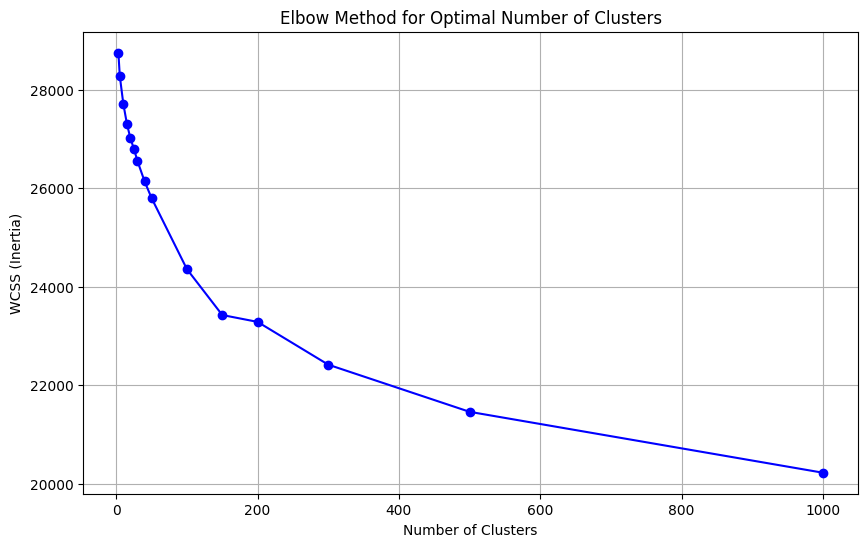

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

cluster_range = [3, 5, 10, 15, 20, 25, 30, 40 , 50, 100, 150, 200, 300, 500, 1000]
inertia_scores = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_tfidf)
    
    inertia_scores.append(kmeans.inertia_)
    print(f"Number of Clusters: {num_clusters}, Inertia: {kmeans.inertia_:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_scores, marker='o', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()